In [1]:
# Install required packages
!pip install albumentations

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the base path
BASE_PATH = '/content/drive/MyDrive/document_layout_analysis'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Create image-mask mapping CSV
def create_mapping_csv(base_path=BASE_PATH):
    images_dir = os.path.join(base_path, 'images')
    masks_dir = os.path.join(base_path, 'masks')

    image_names = []
    mask_names = []

    for image_file in sorted(os.listdir(images_dir)):
        if image_file.startswith('Doc_') and image_file.endswith('.jpg'):
            doc_num = int(image_file.split('_')[1].split('.')[0])
            task_num = doc_num + 30
            mask_file = f'task-{task_num}_combined.png'

            if os.path.exists(os.path.join(masks_dir, mask_file)):
                image_names.append(image_file)
                mask_names.append(mask_file)

    mapping_df = pd.DataFrame({
        'image_name': image_names,
        'mask_name': mask_names
    })

    csv_path = os.path.join(base_path, 'image_mask_mapping.csv')
    mapping_df.to_csv(csv_path, index=False)
    print(f"Created mapping CSV at: {csv_path}")
    print(f"Total mappings created: {len(mapping_df)}")

    return mapping_df

In [6]:
# Modified Dataset class with fixed tensor handling
class DocumentDataset(Dataset):
    def __init__(self, df, base_path, transform=None, target_size=(512, 512)):
        self.df = df
        self.base_path = base_path
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image and mask paths
        img_path = os.path.join(self.base_path, 'images', self.df.iloc[idx]['image_name'])
        mask_path = os.path.join(self.base_path, 'masks', self.df.iloc[idx]['mask_name'])

        # Read image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize to ensure consistent dimensions
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask.long()

Created mapping CSV at: /content/drive/MyDrive/document_layout_analysis/image_mask_mapping.csv
Total mappings created: 600

Dataset Sizes:
Train size: 480
Validation size: 60
Test size: 60

Batch shapes:
Images: torch.Size([4, 3, 512, 512])
Masks: torch.Size([4, 512, 512])


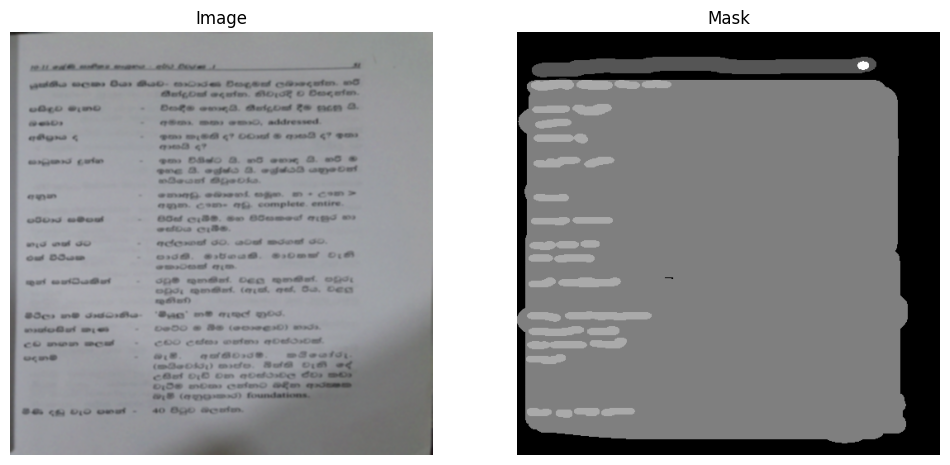

In [7]:
def create_data_pipeline(base_path=BASE_PATH,
                        batch_size=4,
                        target_size=(512, 512),
                        train_size=0.8,
                        val_size=0.1,
                        seed=42):

    # Read the mapping CSV
    df = pd.read_csv(os.path.join(base_path, 'image_mask_mapping.csv'))

    # Create splits
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=seed)
    val_df, test_df = train_test_split(temp_df,
                                      train_size=val_size/(1-train_size),
                                      random_state=seed)

    # Define augmentation pipelines
    train_transform = A.Compose([
        A.ColorJitter(brightness=0.2,
                     contrast=0.2,
                     saturation=0.2,
                     hue=0.1,
                     p=0.7),
        A.RandomBrightnessContrast(
            brightness_limit=0.1,
            contrast_limit=0.1,
            p=0.5
        ),
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

    # Create datasets with fixed target size
    train_dataset = DocumentDataset(train_df, base_path, train_transform, target_size)
    val_dataset = DocumentDataset(val_df, base_path, val_transform, target_size)
    test_dataset = DocumentDataset(test_df, base_path, val_transform, target_size)

    # Create dataloaders with modified settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 for Colab
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # Set to 0 for Colab
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # Set to 0 for Colab
        pin_memory=True
    )

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df
    }

# Create the mapping CSV
mapping_df = create_mapping_csv()

# Create the data pipeline with modified settings
data = create_data_pipeline()

# Print dataset information
print("\nDataset Sizes:")
print(f"Train size: {len(data['train_dataset'])}")
print(f"Validation size: {len(data['val_dataset'])}")
print(f"Test size: {len(data['test_dataset'])}")

# Test a batch
for images, masks in data['train_loader']:
    print(f"\nBatch shapes:")
    print(f"Images: {images.shape}")
    print(f"Masks: {masks.shape}")
    break

# Visualization function
def visualize_sample(dataset, idx=0):
    import matplotlib.pyplot as plt

    image, mask = dataset[idx]

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
        # Denormalize
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        image = image.astype(np.uint8)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

# Visualize a sample
visualize_sample(data['train_dataset'])

In [8]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler  # Added this import

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottom
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = torch.nn.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def initialize_model(device='cuda'):
    model = UNet(in_channels=3, out_channels=1).to(device)

    criterion = nn.BCELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(  # Fixed the scheduler import
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True
    )

    return model, criterion, optimizer, scheduler

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.float().to(device) / 255.0

        optimizer.zero_grad()

        outputs = model(images)
        outputs = torch.sigmoid(outputs)

        masks = masks.unsqueeze(1)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.float().to(device) / 255.0
            masks = masks.unsqueeze(1)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, criterion, optimizer, scheduler = initialize_model(device)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Using device: {device}")

Model Parameters: 31,043,521
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# Training configuration and loop
def train_model(model, data, num_epochs=50):
    best_val_loss = float('inf')
    save_path = '/content/drive/MyDrive/document_layout_analysis/best_model.pth'

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_epoch(model, data['train_loader'], criterion, optimizer, device)
        val_loss = validate(model, data['val_loader'], criterion, device)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with validation loss: {val_loss:.4f}")
            print(f"Model saved at: {save_path}")

# Start training
train_model(model, data)


Epoch 1/50
Batch 0/120, Loss: 0.6708
Batch 10/120, Loss: 0.5525
Batch 20/120, Loss: 0.5414
Batch 30/120, Loss: 0.4944
Batch 40/120, Loss: 0.4451
Batch 50/120, Loss: 0.5006
Batch 60/120, Loss: 0.4512
Batch 70/120, Loss: 0.5341
Batch 80/120, Loss: 0.4594
Batch 90/120, Loss: 0.4590
Batch 100/120, Loss: 0.5572
Batch 110/120, Loss: 0.5388
Train Loss: 0.5215
Val Loss: 0.4640
Saved new best model with validation loss: 0.4640
Model saved at: /content/drive/MyDrive/document_layout_analysis/best_model.pth

Epoch 2/50
Batch 0/120, Loss: 0.5055
Batch 10/120, Loss: 0.5161
Batch 20/120, Loss: 0.5016
Batch 30/120, Loss: 0.4465
Batch 40/120, Loss: 0.4606
Batch 50/120, Loss: 0.4788
Batch 60/120, Loss: 0.5044
Batch 70/120, Loss: 0.5019
Batch 80/120, Loss: 0.5103
Batch 90/120, Loss: 0.5008
Batch 100/120, Loss: 0.5092
Batch 110/120, Loss: 0.4502
Train Loss: 0.4893
Val Loss: 0.4786

Epoch 3/50
Batch 0/120, Loss: 0.4454
Batch 10/120, Loss: 0.4722
Batch 20/120, Loss: 0.4638
Batch 30/120, Loss: 0.4136
Batch 

Loading model...
Calculating metrics...

Model Performance Metrics:
Accuracy: 0.7927
Precision: 0.7047
Recall: 0.6893
F1-Score: 0.6863

Visualizing predictions...


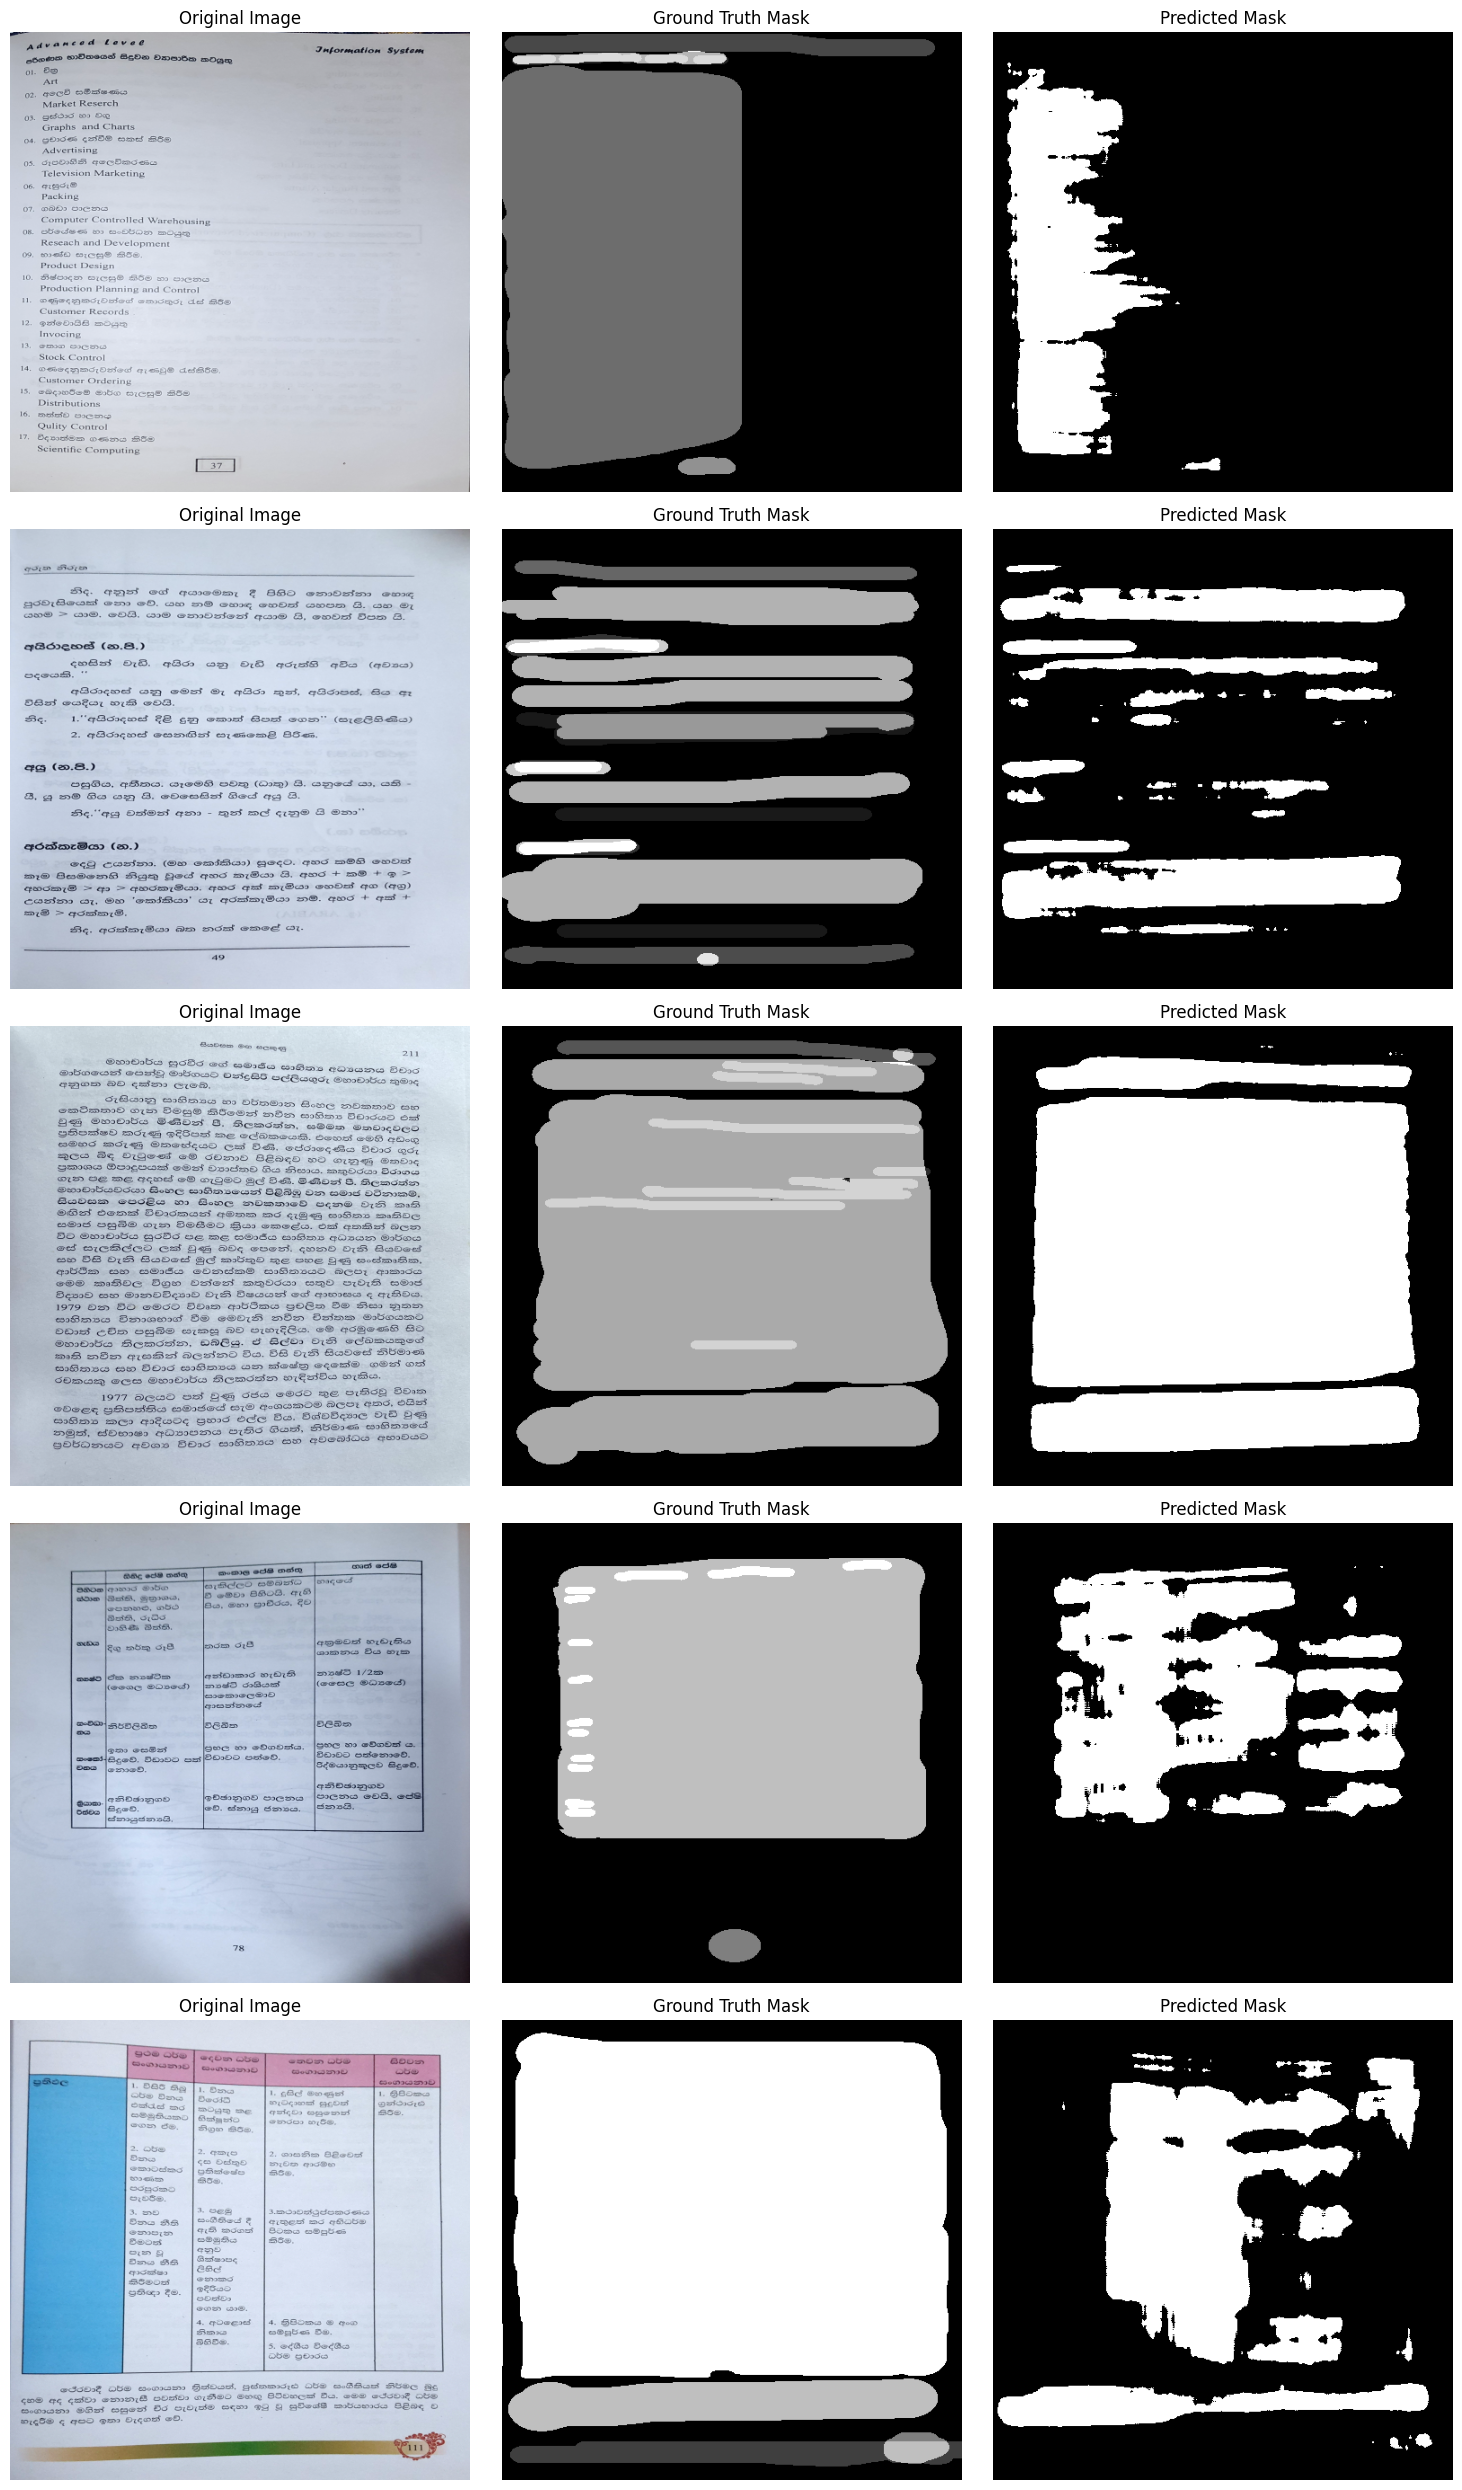

In [15]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

def load_trained_model(model, path):
    # Add weights_only=True as recommended
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    return model

def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate metrics with proper binary conversion"""
    # Ensure binary values
    pred_binary = (predictions > threshold).astype(np.int64)
    target_binary = (targets > threshold).astype(np.int64)

    # Flatten arrays
    pred_flat = pred_binary.flatten()
    target_flat = target_binary.flatten()

    # Calculate metrics
    accuracy = accuracy_score(target_flat, pred_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(
        target_flat,
        pred_flat,
        average='binary',
        zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def evaluate_model(model, test_loader, device, threshold=0.5):
    model.eval()
    all_metrics = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.float().to(device) / 255.0
            masks = masks.unsqueeze(1)

            # Get predictions
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # Convert to numpy for metric calculation
            predictions = outputs.cpu().numpy()
            targets = masks.cpu().numpy()

            # Calculate metrics for this batch
            batch_metrics = calculate_metrics(predictions, targets, threshold)
            all_metrics.append(batch_metrics)

    # Average metrics across all batches
    avg_metrics = {
        key: np.mean([m[key] for m in all_metrics])
        for key in all_metrics[0].keys()
    }

    return avg_metrics

def visualize_predictions(model, test_loader, device, num_samples=5):
    """Visualize some test predictions alongside ground truth"""
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            if idx >= num_samples:
                break

            images = images.to(device)
            masks = masks.float() / 255.0

            # Get predictions
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            predictions = (outputs > 0.5).float()

            # Convert tensors to numpy for visualization
            image = images[0].cpu().permute(1, 2, 0).numpy()
            mask = masks[0].cpu().numpy()
            pred = predictions[0, 0].cpu().numpy()

            # Normalize image for visualization
            image = (image - image.min()) / (image.max() - image.min())

            # Plot
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(mask, cmap='gray')
            axes[idx, 1].set_title('Ground Truth Mask')
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(pred, cmap='gray')
            axes[idx, 2].set_title('Predicted Mask')
            axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Load the trained model
print("Loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/document_layout_analysis/best_model.pth'
model = load_trained_model(model, model_path)

# Calculate metrics
print("Calculating metrics...")
metrics = evaluate_model(model, data['test_loader'], device)

# Print metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")

# Visualize some predictions
print("\nVisualizing predictions...")
visualize_predictions(model, data['test_loader'], device)

Loading model...

Evaluating datasets...

Comprehensive Model Evaluation:
            Accuracy  Precision  Recall  F1-Score
Dataset                                          
Training      0.8020     0.6195  0.7609    0.6830
Validation    0.8485     0.6083  0.7702    0.6797
Test          0.7927     0.7112  0.6985    0.7048


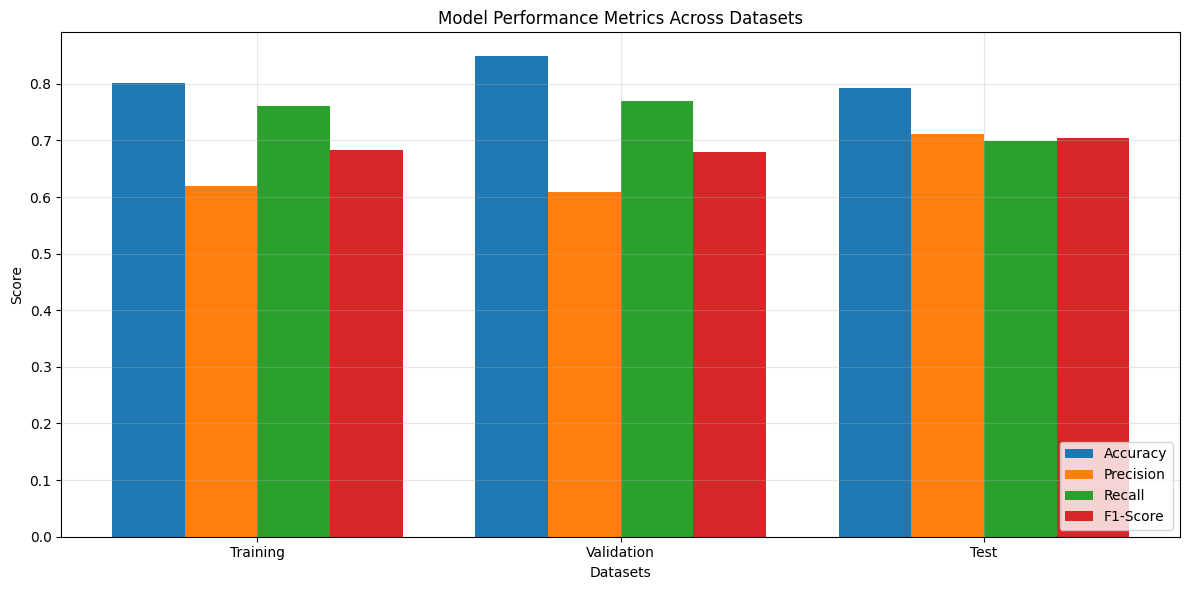


Metrics saved to: /content/drive/MyDrive/document_layout_analysis/model_metrics.csv

Performance Analysis:
--------------------------------------------------------------------------------
Accuracy:
Train-Validation Gap: 0.0465
Train-Test Gap: 0.0093
----------------------------------------
Precision:
Train-Validation Gap: 0.0112
Train-Test Gap: 0.0917
----------------------------------------
Recall:
Train-Validation Gap: 0.0093
Train-Test Gap: 0.0624
----------------------------------------
F1-Score:
Train-Validation Gap: 0.0032
Train-Test Gap: 0.0218
----------------------------------------


In [16]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_dataset(model, loader, device, dataset_name="", threshold=0.5):
    """Evaluate model on a specific dataset"""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.float().to(device) / 255.0
            masks = masks.unsqueeze(1)

            # Get predictions
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # Convert to binary predictions
            predictions = (outputs > threshold).cpu().numpy()
            targets = (masks > threshold).cpu().numpy()

            all_predictions.extend(predictions.flatten())
            all_targets.extend(targets.flatten())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets,
        all_predictions,
        average='binary',
        zero_division=0
    )

    metrics = {
        'Dataset': dataset_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    return metrics

# Load the trained model
print("Loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/document_layout_analysis/best_model.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

# Evaluate all datasets
print("\nEvaluating datasets...")
metrics_train = evaluate_dataset(model, data['train_loader'], device, "Training")
metrics_val = evaluate_dataset(model, data['val_loader'], device, "Validation")
metrics_test = evaluate_dataset(model, data['test_loader'], device, "Test")

# Combine all metrics into a DataFrame
all_metrics = pd.DataFrame([metrics_train, metrics_val, metrics_test])
all_metrics = all_metrics.set_index('Dataset')

# Print formatted metrics
print("\nComprehensive Model Evaluation:")
print("=" * 80)
print(all_metrics.round(4).to_string())
print("=" * 80)

# Visualize metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
datasets = ['Training', 'Validation', 'Test']

plt.figure(figsize=(12, 6))
x = np.arange(len(datasets))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = [metrics_train[metric], metrics_val[metric], metrics_test[metric]]
    plt.bar(x + i*width, values, width, label=metric)

plt.xlabel('Datasets')
plt.ylabel('Score')
plt.title('Model Performance Metrics Across Datasets')
plt.xticks(x + width*1.5, datasets)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save metrics to CSV
metrics_file_path = '/content/drive/MyDrive/document_layout_analysis/model_metrics.csv'
all_metrics.to_csv(metrics_file_path)
print(f"\nMetrics saved to: {metrics_file_path}")

# Calculate and print performance gaps
print("\nPerformance Analysis:")
print("-" * 80)
for metric in metrics_to_plot:
    train_score = metrics_train[metric]
    val_score = metrics_val[metric]
    test_score = metrics_test[metric]

    train_val_gap = abs(train_score - val_score)
    train_test_gap = abs(train_score - test_score)

    print(f"{metric}:")
    print(f"Train-Validation Gap: {train_val_gap:.4f}")
    print(f"Train-Test Gap: {train_test_gap:.4f}")
    print("-" * 40)